<a href="https://colab.research.google.com/github/thomasp05/GIF-7005-Projet/blob/features%2Ftest-unet/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pre-configuration

## Mount Google Drive

In [1]:
# Set up colab instance
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Clone and pull github repository

In [2]:
# Make sure clone at root
%cd /content

!pip3 install pydicom
!git clone https://github.com/thomasp05/gif-705-projet

import os
os.chdir('gif-705-projet')

# Add the local_modules directory to the set of paths
# Python uses to look for imports.
import sys
sys.path.append('/content/gif-705-projet')

/content
     |████████████████████████████████| 1.9MB 5.9MB/s 
Cloning into 'gif-705-projet'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 160 (delta 89), reused 94 (delta 44), pack-reused 0
Receiving objects: 100% (160/160), 134.33 KiB | 7.90 MiB/s, done.
Resolving deltas: 100% (89/89), done.


Checkout branch

In [3]:
!git checkout "features/test-unet" #develop
!git pull

Branch 'features/test-unet' set up to track remote branch 'features/test-unet' from 'origin'.
Switched to a new branch 'features/test-unet'
Already up to date.


# Imports and load

In [4]:
import time

import torch


from dataset import *

from models import *
import models_parts
from train_helper import *

from torch.optim import lr_scheduler


torch.manual_seed(111)

## HYPERPARAMETERS

In [5]:
N_EPOCH = 1
start_epoch = 0
BATCH_SIZE = 4
google_drive_path = "/content/drive/My Drive/GIF-7005-Projet/"
checkpoint_path = google_drive_path + "checkpoint/" 

## Load dataset

In [6]:
dataset = dcm_dataset(google_drive_path + 'gif-7005-projet/data', transforms=Downsample())
print("Found {} images".format(len(dataset.img_files)))

train_set, test_set = train_test_split(dataset)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, num_workers=2)

dataloaders = {
  'train': train_loader,
  'val': test_loader
}

Found 26684 images


# UNet

Instantiate Model, optimizer and loss function

In [9]:
model = UNet(n_channels=1, n_classes=1).to("cuda:0")

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)

## Load model checkpoint

In [10]:
file_path = checkpoint_path + "unet_train.pt"
model, optim, start_epoch, best_loss = load_checkpoint(model, optim, file_path)
transfer_optimizer_parts(optim)

=> no checkpoint found at '/content/drive/My Drive/GIF-7005-Projet/checkpoint/unet_drive.pt'


## Simple Train

In [15]:
# Test inference
timer = time.time()
for epoch in range(start_epoch, N_EPOCH):
  for img, (target, bounding_box) in train_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    loss = criterion(out, bounding_box)
    loss.backward()

    optim.step()

  print("Epoch : {}".format(epoch+1))
  print("Time  : {:.2f}".format(time.time()-timer))

Epoch : 1
Time  : 2864.73


In [16]:
#checkpoint_path = google_drive_path + "unet_drive.pt"
#torch.save(model.state_dict(), checkpoint_path)

save_checkpoint(epoch, model, optim, loss, file_path)

In [17]:
out_images = checkpoint_path + "out_images_after_train.pt"
torch.save(out, out_images)

### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

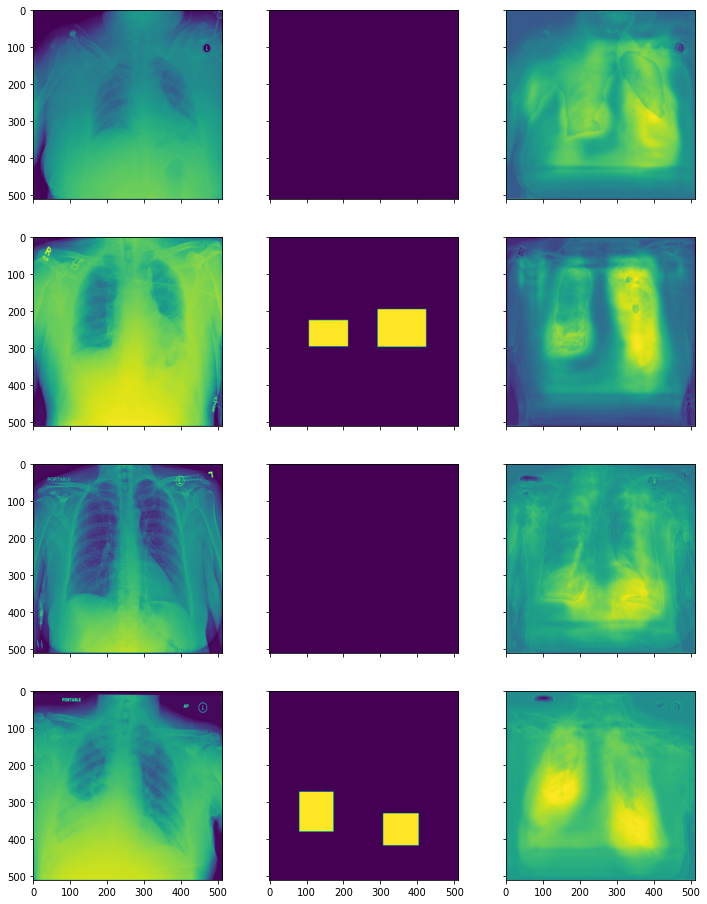

In [18]:
plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()]) #


## Train

In [9]:

#checkpoint_path = google_drive_path + "unet_train_8_epochs.pt"

model = train_model(model, optim, exp_lr_scheduler, dataloaders, N_EPOCH, file_path, best_loss)

Epoch 1/8
--------------------


KeyboardInterrupt: ignored

### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

In [ ]:
for img, (target, bounding_box) in test_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    break

plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()])


NEW TEST

In [ ]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, (_, labels)) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


# ResNet UNet

Instantiate Model

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class=1).to(device)

optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=8, gamma=0.1)

Freeze backbone layers

In [21]:
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False

## Load model checkpoint

In [22]:
file_path = checkpoint_path + "resnet_unet.pt"
model, optim, start_epoch, best_loss = load_checkpoint(model, optim, file_path)
transfer_optimizer_parts(optim)

=> no checkpoint found at '/content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt'


## Simple Train

In [23]:
# Test inference

timer = time.time()
for epoch in range(N_EPOCH):
  for img, (target, bounding_box) in train_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    loss = criterion(out, bounding_box)
    loss.backward()

    optim.step()

  print("Epoch : {}".format(epoch+1))
  print("Time  : {:.2f}".format(time.time()-timer))

Epoch : 1
Time  : 1403.56


In [24]:
#checkpoint_path = google_drive_path + "ResNetUNet_drive.pt"
#torch.save(model.state_dict(), checkpoint_path)

save_checkpoint(epoch, model, optim, loss, file_path)

In [25]:
checkpoint_path = google_drive_path + "out_images_after_train_ResNetUNet.pt"
torch.save(out, checkpoint_path)

### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

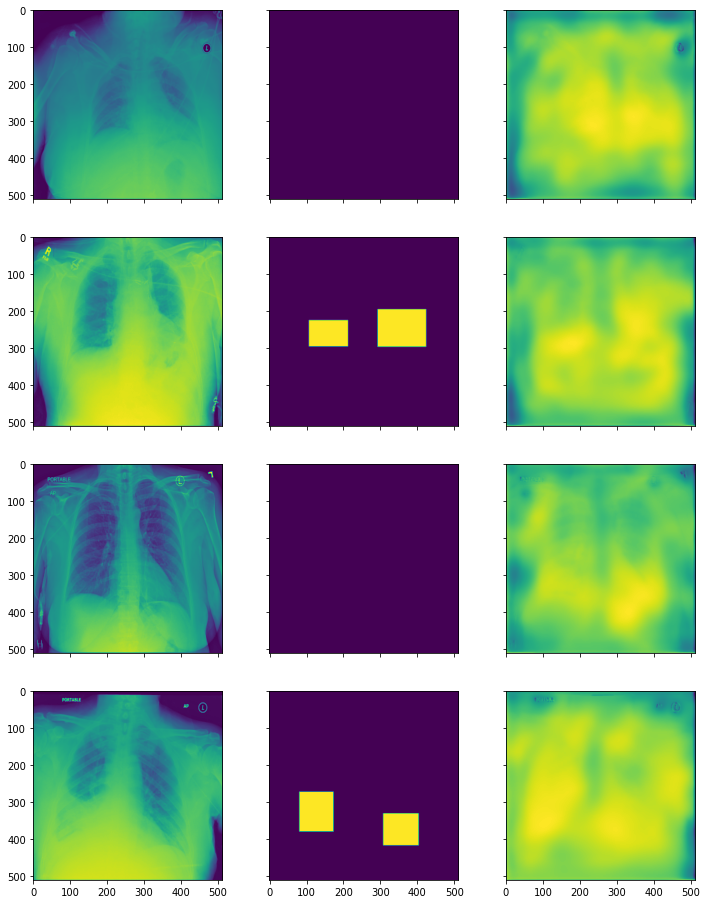

In [26]:
plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()]) #


## Train

In [27]:
model = train_model(model, optim, exp_lr_scheduler, dataloaders, N_EPOCH, file_path, best_loss)

Epoch 1/1
--------------------
train: bce: 0.295814, dice: 0.323165, loss: 0.309490
LR 0.0001
val: bce: 0.197146, dice: 0.368135, loss: 0.282641
saving best model to /content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt
35m 52s
Best val loss: 0.282641


### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

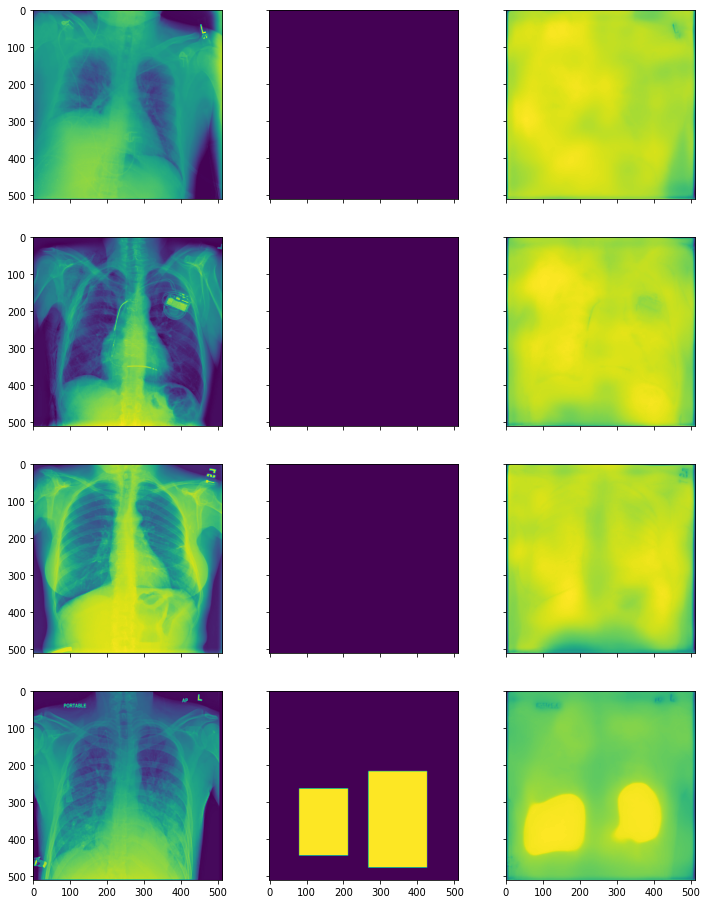

In [28]:
for img, (target, bounding_box) in test_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    break

plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()])
